##Scripts for Homework 8.1

In order to do the homework, you will first need to download the ISO data, which is in file [ISO_data](https://drive.google.com/file/d/1OccasoEZ61Uh-p-F1aBzaKdj1mUWL0qk/view?usp=sharing). Download  the data into a Google Drive folder. Run the script below to make sure that you can access the data.

The list of files is


2020_CT.txt    
2020_NH.txt     
2020_VT.txt    
2020_ME.txt    
2020_RI.txt    
2020_WCMA.txt  
2020_NEMA.txt     
2020_SEMA.txt  

2021_CT.txt     
2021_NH.txt     
2021_VT.txt    
2021_ME.txt     
2021_RI.txt    
2021_WCMA.txt    
2021_NEMA.txt    
2021_SEMA.txt

##How to write your assignment

**Describe the experiment**
  * Describe the data: two years of load records for Connecticut
  * What do we do with the data: We want to forecast the load M hours in advance
  * How we will do the forecast: Describe the GP (Square exp. -RBF- kernel)
  * How the data is preprocessed

**Present the results**
  * Show the necessary figures. Number and reference them. For example "Figure 1 shows the prediction of the load day 1 of year 2021 at a forecast horizon M=1".  The figure must have a caption summarizing what it is.

**Discusion**
  * What knowledge can be extracted from the figures? For example: "There is a difference between the confidence intervals (CI) in Fig. 1 and Fig 2. because..."

**Conclusion**
  * Not really needed for this assignment. We presented the experiments... The results show that the performance is adequate... It is important to see that the CI changes dramatically with M...


In [ ]:
%cd /content/drive/MyDrive/ECE517/ISO data
#Change the name of the folder to the name of the folder where you data is.
%ls *.txt
#You should be able to see the list of data below.

[Errno 2] No such file or directory: '/content/drive/MyDrive/ECE517/ISO data'
/content
2020_CT.txt  2020_NEMA.txt  2020_RI.txt    2020_VT.txt    2021_CT.txt
2020_ME.txt  2020_NH.txt    2020_SEMA.txt  2020_WCMA.txt


You will need to import the following libraries for numerical computation,s representation, the GP class including kernels and the data prerprocessing library, that will be explained below..

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn import preprocessing

The following functions are needed for the data formatting and representation. They are described below.

In [ ]:
def sliding_window(x, w = 1, d = 0):
    # This function creates a data array formatted in sliding windows.
    # Parameters: X, the input data, which must be a time series in an array of a singel dimension
    #             w, the width of the window
    #             d, the number of elements of the previous window present in the next one.
    #             For the present homework, we use a window shift of 1 position, so then d = w-1
    #             X is the output, and it is an array with the formatted data.
    N = len(x)
    x=x.reshape(x.size,)
    m = int(np.ceil((N-w)/(w-d)))
    X = np.zeros([w,m])
    for i,j in zip(range(0,N,w-d),range(0,m)):
        X[:,j] = x[i:i + w]
    return X

def plot_graphs(y_tst,mean,std,title):
  # This plots the results of the GP prediction, so you do not spend time figuring this out.
  # Parameters: y_tst is the time series of true regressors
  #             mean is the mean value of the prediction
  #             std is the standard deviation of the prediction
  #             tittle is a string with the title that you want to show in the graphic.
  plt.plot(y_tst_raw[:L,], label="Observations",color="green")
  plt.plot(mean_raw, label="Mean prediction",color="red")
  plt.fill_between(
    np.arange(y_tst[:L,].size).ravel(),
    mean_raw - 1.96 * std_raw,
    mean_raw + 1.96 * std_raw,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$t$")
  plt.ylabel("$f(t)$")
  plt.title(title)
  plt.show()

This is how you read a set of data (the training dataset is the 2020 Connecticut time series, and the test corresponds to the 2021 series of the same state) and plot it. The plot corresponds to the second day of January, 2020.

We call them x_train_raw and x_tst_raw, because before using it, we need to normalize it  

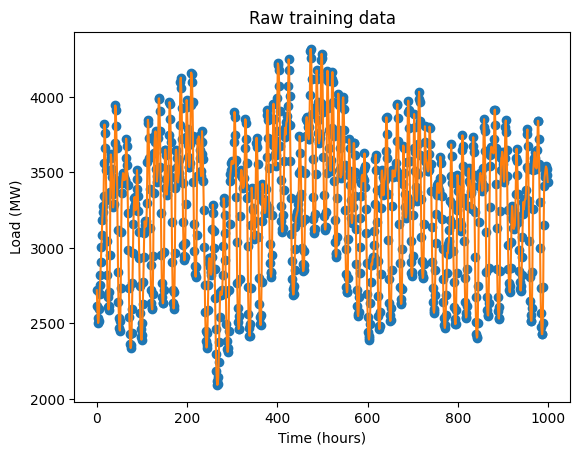

In [ ]:
x_train_raw=np.loadtxt("2020_CT.txt", dtype = float)
x_train_raw=x_train_raw.reshape(x_train_raw.size,1) # Here we need to convert it to an array with (N,1) dimensions for the normalization function to accept it.

plt.plot(x_train_raw[:1000],'o')
plt.plot(x_train_raw[:1000])
plt.title("Raw training data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.show()

Now, we standardize the data, this is, we extract the mean and divide by the standard deviation. To do this, we use class preprocessing.StandardScaler()

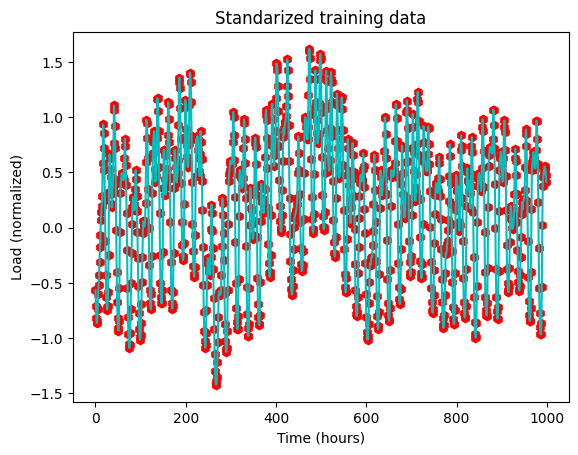

In [ ]:
scaler = preprocessing.StandardScaler().fit(x_train_raw)  # This method computes the mean and the variance of the training data
x_train = scaler.transform(x_train_raw)                   # This method standarizes any data, this is, it subtracts the previously computed
                                                          # mean and divides by the previously computed standard deviation

x_tst_raw=np.loadtxt("2021_CT.txt", dtype = float)        # Here we load the test data
x_tst_raw=x_tst_raw.reshape(x_tst_raw.size,1)             # Here we convert the data to (N,1)
x_tst = scaler.transform(x_tst_raw)                       # And we standarize this data with the mean and variance of the training data.

# We plot one day of the training data after standarization.
plt.plot(x_train[0:1000],'h', color='r')
plt.plot(x_train[0:1000], color='c')
plt.title("Standarized training data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (normalized)')
plt.show()

Now we format the data. Refer to the class explanations to fully understand this.  

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
#Data formatting and training
W=24
M=12 # Prediction horizon of M hours


X_train=sliding_window(x_train[:-M],W,W-1).T # W is the window length and W-S is such that S is the sliding intervals
y_train=x_train[M+W-1:]

X_tst=sliding_window(x_tst[:-M],W,W-1).T
y_tst=x_tst[M+W-1:]


In [ ]:
print(X_train.shape)
print(y_train.shape)

(8730, 24)
(8731, 1)


In order to plot the data in its original format, the following method unnormalizes it by multiplying it times the standard deviation of the training data and adding its mean. Below is an example where the test regressors are unnormalized. You have to do it with the GP predictions before plotting the results.

The standard deviation of the prediction has to be unnormalized by multiplying by the standard deviation of the training data. The variance of the training data is in variable scaler.var_

[536032.81898615]


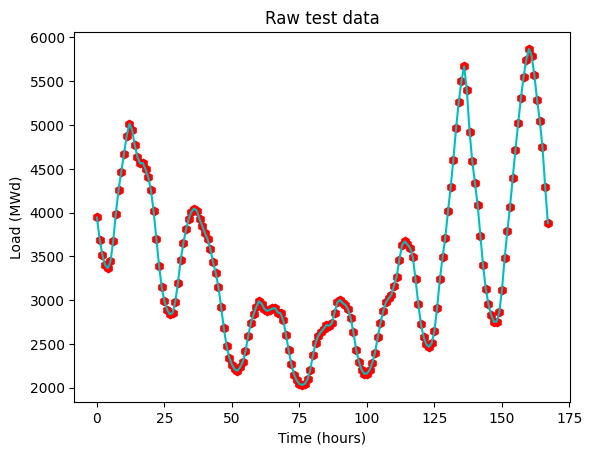

In [ ]:
y_tst_raw=scaler.inverse_transform(y_tst)
print(scaler.var_)
plt.plot(x_tst_raw[4344:4512],'h', color='r')
plt.plot(x_tst_raw[4344:4512], color='c')
plt.title("Raw test data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MWd)')
plt.show()

In [ ]:
kernel = 1*RBF(1) + WhiteKernel(0.1)

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)
gaussian_process.fit(X_train[:1000,:], y_train[:1000,:])

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=1)

In [ ]:
L=168 #We use only 48 hours for the prediction
mean, std = gaussian_process.predict(X_tst[4344:4512,:], return_std=True)

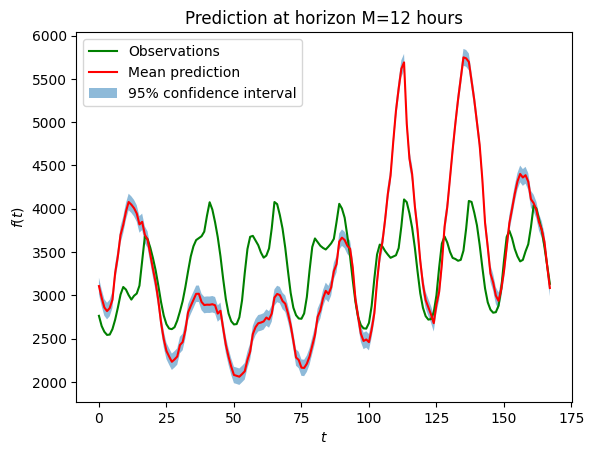

In [ ]:
mean_raw=scaler.inverse_transform(mean.reshape(mean.size,1)).reshape(mean.size,)
std_raw=std*np.sqrt(scaler.var_)
y_tst_raw=scaler.inverse_transform(y_tst)
plot_graphs(y_tst_raw,mean_raw,std_raw,"Prediction at horizon M="+str(12)+" hours")

In [ ]:
gaussian_process.kernel_

5.88**2 * RBF(length_scale=9.27) + WhiteKernel(noise_level=0.0019)

In [ ]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Define a linear kernel
linear_kernel = 1 * DotProduct() + WhiteKernel(0.1)

# Create the Gaussian Process Regressor with the linear kernel
gaussian_process_linear = GaussianProcessRegressor(kernel=linear_kernel, n_restarts_optimizer=1)

# Fit the model (assuming you have X_train and y_train defined)
gaussian_process_linear.fit(X_train[:1000, :], y_train[:1000, :])

GaussianProcessRegressor(kernel=1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=1)

In [ ]:
L=168 #We use only 48 hours for the prediction
mean, std = gaussian_process_linear.predict(X_tst[:L,:], return_std=True)

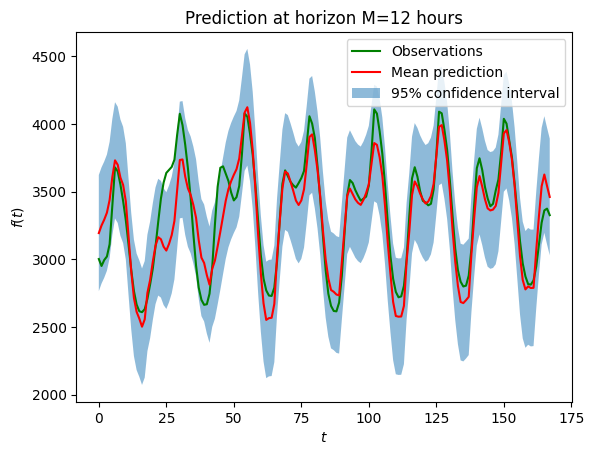

In [ ]:
mean_raw=scaler.inverse_transform(mean.reshape(mean.size,1)).reshape(mean.size,)
std_raw=std*np.sqrt(scaler.var_)
y_tst_raw=scaler.inverse_transform(y_tst)
plot_graphs(y_tst_raw,mean_raw,std_raw,"Prediction at horizon M="+str(12)+" hours")